In [4]:
import pickle
from pathlib import Path
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

from gnn import Experiment, HyperParameter, Metric, MetricName, MotterLaiData

In [5]:
new_rc_params: dict[str, Any] = {
    # Default parameters for plot
    # * text
    "font.size": 40,
    "font.family": "Times New Roman",
    "text.usetex" : True,
    "text.latex.preamble": r"\usepackage{amsmath}",

    # * figure
    "figure.figsize": (8, 8),
    "figure.facecolor": "white",
    "axes.linewidth": 3,
    "image.aspect": "equal",
    # * line
    "lines.linewidth": 3,
    "lines.markersize": 7,
    # * legend
    "legend.frameon": False,
    "legend.fontsize": 30,
    "legend.handlelength": 1.0,
    "legend.handletextpad": 0.5,
    "legend.labelspacing": 0.2,
    "legend.borderaxespad": 0.4,
    # * label
    "axes.labelsize": 35,
    # * tick
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.width": 3,
    "ytick.major.width": 3,
    "xtick.major.size": 10,
    "ytick.major.size": 10,
    "xtick.minor.width": 1,
    "ytick.minor.width": 1,
    "xtick.minor.size": 5,
    "ytick.minor.size": 5,
    # * tick label
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "xtick.major.pad": 10,
    "ytick.major.pad": 10,
    # * save
    "savefig.facecolor": "#ffffff",
    "savefig.bbox": "tight",
    "savefig.format": "pdf",
}
mpl.rcParams.update(new_rc_params)

In [11]:
RANK_EXPERIMENT = [1, 2, 3, 4]
VALUE_EXPERIMENT = [5, 6, 7, 8]

SHK_NETWORK = [
    "shk_rand_0.25",
    "shk_1000_0.25",
    "shk_2000_0.25",
    "shk_3000_0.25",
    "shk_4000_0.25",
    "shk_5000_0.25",
    "shk_6000_0.25",
    "shk_7000_0.25",
    "shk_8000_0.25",
]

BASE_DIR = Path(".")
EXPERIMENT_DIR = BASE_DIR / "experiment"

In [12]:
mcf_rank: dict[str, list[float]] = {n: [] for n in SHK_NETWORK}
kt_rank: dict[str, list[float]] = {n: [] for n in SHK_NETWORK}
r2_rank: dict[str, list[float]] = {n: [] for n in SHK_NETWORK}

for exp_id in RANK_EXPERIMENT:
    hp = HyperParameter.load(exp_id, EXPERIMENT_DIR)
    experiment = Experiment.from_id(exp_id, EXPERIMENT_DIR)
    for shk_network in SHK_NETWORK:
        data = MotterLaiData.from_hp(
            stage="TEST", hp=hp, network_list=shk_network, scaler=experiment.scaler
        )
        metric = Metric("TEST")
        pred_list, _ = experiment.evaluate(data, metric)
        mcf_rank[shk_network].append(metric.avg_dict[MetricName.MCF])
        kt_rank[shk_network].append(metric.avg_dict[MetricName.KT])
        r2_rank[shk_network].append(metric.avg_dict[MetricName.R2])


mcf_value: dict[str, list[float]] = {n: [] for n in SHK_NETWORK}
kt_value: dict[str, list[float]] = {n: [] for n in SHK_NETWORK}
r2_value: dict[str, list[float]] = {n: [] for n in SHK_NETWORK}
for exp_id in VALUE_EXPERIMENT:
    hp = HyperParameter.load(exp_id, EXPERIMENT_DIR)
    experiment = Experiment.from_id(exp_id, EXPERIMENT_DIR)

    for shk_network in SHK_NETWORK:
        data = MotterLaiData.from_hp(
            stage="TEST", hp=hp, network_list=shk_network, scaler=experiment.scaler
        )
        metric = Metric("TEST")
        experiment.evaluate(data, metric)
        mcf_value[shk_network].append(metric.avg_dict[MetricName.MCF])
        kt_value[shk_network].append(metric.avg_dict[MetricName.KT])
        r2_value[shk_network].append(metric.avg_dict[MetricName.R2])

Load experiment from epoch 229
Load experiment from epoch 415
Load experiment from epoch 502
Load experiment from epoch 245
Load experiment from epoch 540
Load experiment from epoch 153
Load experiment from epoch 154
Load experiment from epoch 62


In [13]:
def get_statistics(
    metric_dict: dict[str, list[float]]
) -> tuple[list[float], list[float]]:
    return [np.mean(v).item() for v in metric_dict.values()], [
        np.std(v).item() for v in metric_dict.values()
    ]

def plot_bars(
    ax: plt.Axes,
    avg1: list[float],
    err1: list[float],
    avg2: list[float],
    err2: list[float],
) -> None:
    ax.bar(
        SHK_NETWORK,
        avg1,
        width=-0.4,
        yerr=err1,
        capsize=5,
        linewidth=1.0,
        align="edge",
        label="predict rank",
        color="#cecdff",
        edgecolor="#2e1dff",
    )
    ax.bar(
        SHK_NETWORK,
        avg2,
        width=0.4,
        yerr=err2,
        capsize=5,
        linewidth=1.0,
        align="edge",
        label="predict value",
        color="#d2a3cd",
        edgecolor="#f30000",
    )


def plot_a(ax: plt.Axes):
    avg1, err1 = get_statistics(r2_rank)
    avg2, err2 = get_statistics(r2_value)

    plot_bars(ax, avg1, err1, avg2, err2)

    ax.set_xticklabels(["train", 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
    ax.tick_params(axis="both", labelsize=20)
    ax.set_xlabel("$N$")
    ax.set_ylabel(r"$R^2\ score$")
    ax.set_yscale("symlog")
    ax.set_ylim(top=1.5)
    ax.text(0.05, 0.9, "(a)", transform=ax.transAxes, fontsize=30)
    ax.legend(fontsize=20, loc="upper right")


def plot_b(ax1: plt.Axes, ax2: plt.Axes):
    avg1, err1 = get_statistics(mcf_rank)
    avg2, err2 = get_statistics(mcf_value)

    plot_bars(ax1, avg1, err1, avg2, err2)
    plot_bars(ax2, avg1, err1, avg2, err2)

    ax1.set_ylim(0.85, 1.0)
    ax1.spines["bottom"].set_visible(False)
    ax1.set_yticks([0.90, 0.95, 1.0])
    ax1.legend(fontsize=20, loc="upper right")
    ax1.text(0.05, 0.80, "(b)", transform=ax1.transAxes, fontsize=30)
    ax1.tick_params(axis="y", labelsize=20)
    ax1.set_xticks([])
    ax1.tick_params(labeltop=False)
    ax1.text(
        -0.2,
        -0.2,
        r"$\langle C_{\sigma}\rangle_N$",
        fontsize=35,
        rotation=90,
        transform=ax1.transAxes,
    )

    ax2.set_ylim(0.5, 0.75)
    ax2.spines["top"].set_visible(False)
    ax2.xaxis.tick_bottom()
    ax2.set_yticks([0.5, 0.6, 0.7])
    ax2.set_xticklabels(["train", 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
    ax2.tick_params(axis="both", labelsize=20)
    ax2.set_xlabel("$N$", usetex=True)
    # ax1.set_ylabel(r"$\langle C_{\sigma, N} \rangle$", usetex=True)

    d = 0.1
    kwargs = dict(
        marker=[(-1, -d), (1, d)],
        markersize=20,
        linestyle="none",
        color="k",
        mec="k",
        mew=2,
        clip_on=False,
    )
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


def plot_c(ax: plt.Axes):
    avg1, err1 = get_statistics(kt_rank)
    avg2, err2 = get_statistics(kt_value)

    plot_bars(ax, avg1, err1, avg2, err2)

    ax.set_xticklabels(["train", 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
    ax.tick_params(axis="both", labelsize=20)
    ax.set_xlabel("$N$")
    ax.set_ylabel(r"$\tau$")
    ax.set_ylim(0.5, 1.0)
    ax.text(0.05, 0.9, "(c)", transform=ax.transAxes, fontsize=30)
    ax.legend(fontsize=20, loc="upper right")

/tmp/ipykernel_1203569/4234355124.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["train", 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
/tmp/ipykernel_1203569/4234355124.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(["train", 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
/tmp/ipykernel_1203569/4234355124.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["train", 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])


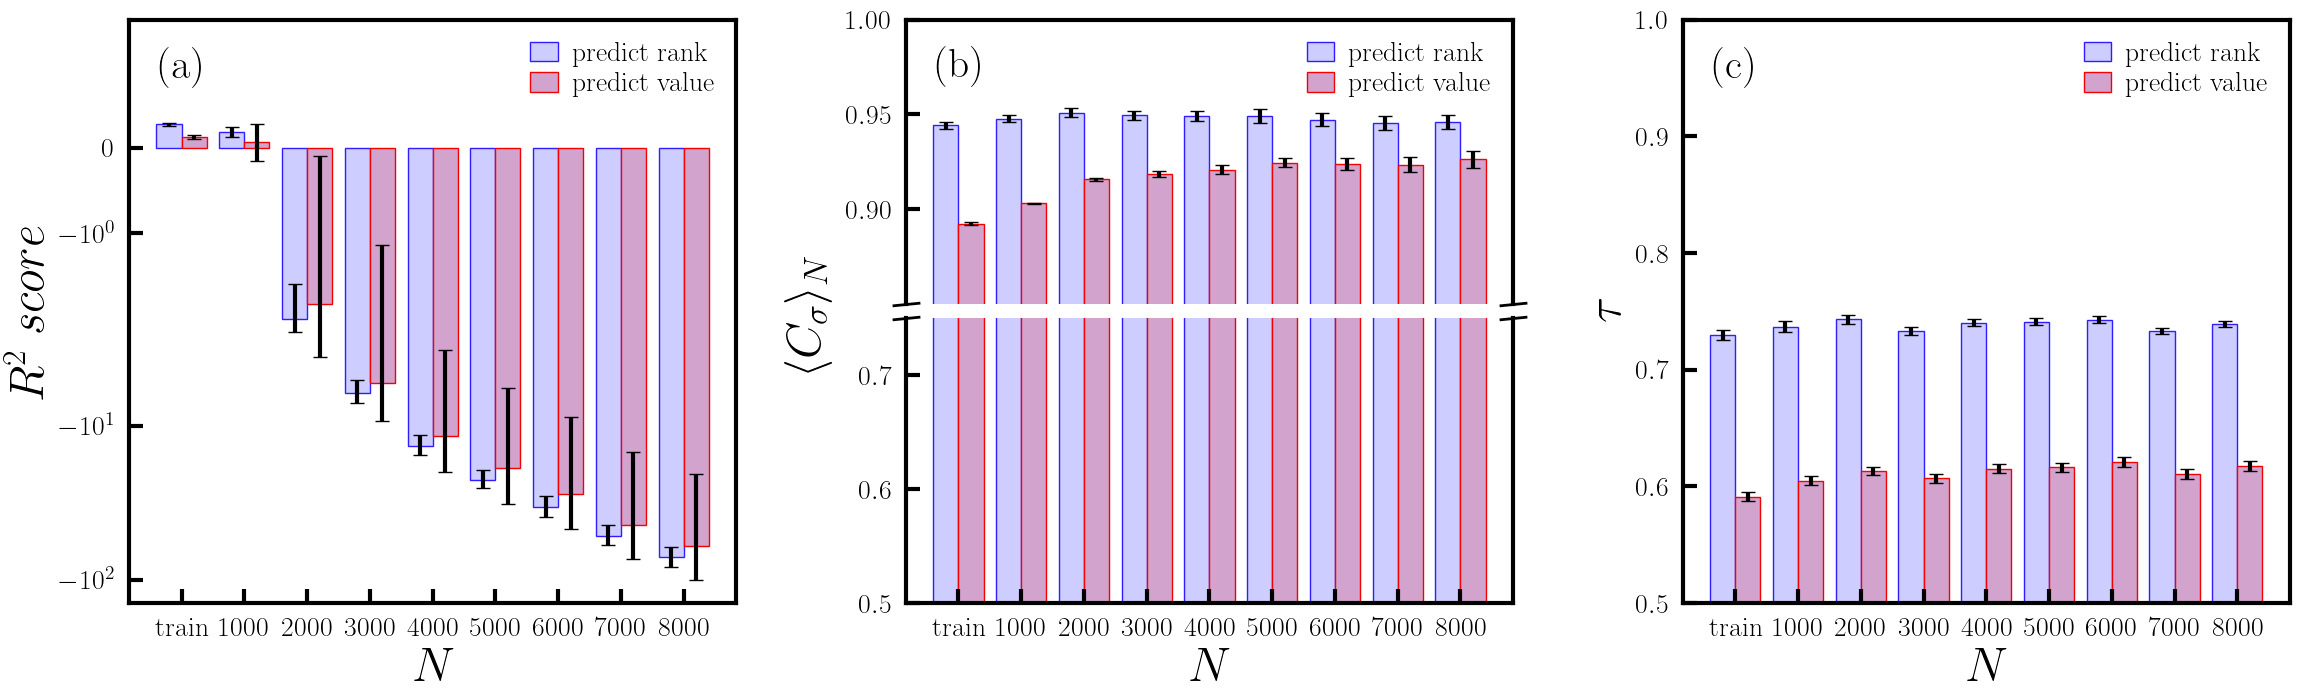

In [14]:
fig = plt.figure(figsize=(24, 8))
gs = GridSpec(2, 3, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[:, 2])

plot_a(ax1)
plot_b(ax2, ax3)
plot_c(ax4)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05)

fig.show()